In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from spyci import spyci

In [34]:
raw_file='6_bit_dac.raw'
no_of_bits = 6
max_voltage = 3.30
spline_smoothing = 600
threshold = 0.26

## Get list of vectors in raw file

In [33]:
spyci.list_vars(raw_file)
data=spyci.load_raw(raw_file)

Variables:

  idx  name     type
-----  -------  -------
    1  v(d0)    voltage
    2  v(vout)  voltage


## Select which vector names to use

In [35]:
vector_names=['v(d0)','v(vout)']

## Show the contents of the raw file for selected vectors

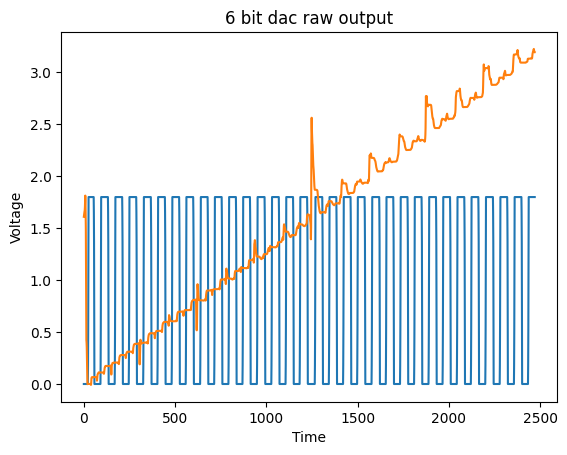

In [38]:
v_d0=data['values'][vector_names[0]].real
vout=data['values'][vector_names[1]].real

plt.title( str(no_of_bits)+" bit dac raw output")
plt.ylabel("Voltage")
plt.xlabel("Time")
plt.plot(v_d0[:3000])
plt.plot(vout[:3000])
plt.show()

In [14]:
import numpy as np

def detect_edges(signal):
    edges = []
    previous_value = signal[0]

    for i in range(1, len(signal)):
        current_value = signal[i]

        if current_value != previous_value:
            edges.append(i)

        previous_value = current_value

    return edges

def create_pulses(signal,threshold):
    pulse = np.zeros_like(signal)
    previous_value = signal[0]
    pulse_flag = False

    for i in range(1, len(signal)):
        current_value = signal[i]

        slope = current_value - previous_value

        if abs(slope) > threshold:  # Adjust the threshold as needed
            if not pulse_flag:
                pulse[i] = 1
                pulse_flag = True
        else:
            pulse_flag = False

        previous_value = current_value

    return pulse


### Find the indexes where by edge detection (Reduce 'threshold' value if both rising and falling edge not detected)

indices_found: 63


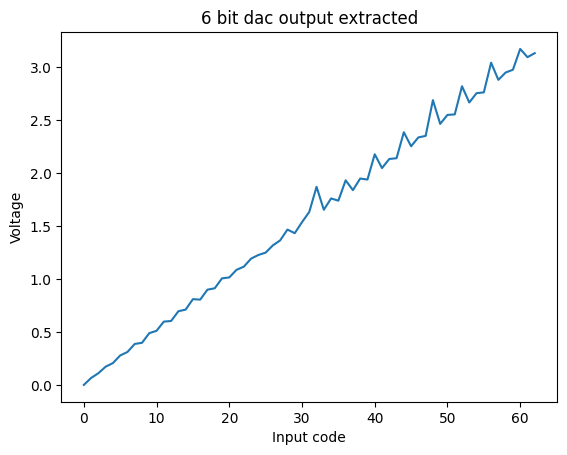

In [39]:
# Create pulses at the edge positions
pulse = create_pulses(v_d0,threshold)
indices = np.where(pulse == 1)[0]
print("indices_found:",len(indices))
elements = vout[indices]

plt.title( str(no_of_bits)+" bit dac output extracted")
plt.ylabel("Voltage")
plt.xlabel("Input code")
plt.plot(elements)
plt.show()

# DNL measurement

In [19]:
step_sizes = np.diff(elements)

vlsb_ideal=max_voltage/pow(2,no_of_bits)

dnl=(step_sizes/vlsb_ideal)-1
print("Ideal step size:", vlsb_ideal)

# plt.plot(dnl)
# plt.show()

Ideal step size: 0.0515625


# INL measurement

In [20]:
#INL=o/p value for i/p code - o/p value of the reference line at that point
INL=[]
for x in range(elements.size):
    ref_value=x*(max_voltage/pow(2,no_of_bits))
    op_value=elements[x]
    INL.append(op_value-ref_value)
    
# plt.plot(INL)
# plt.show()

## Plotting INL

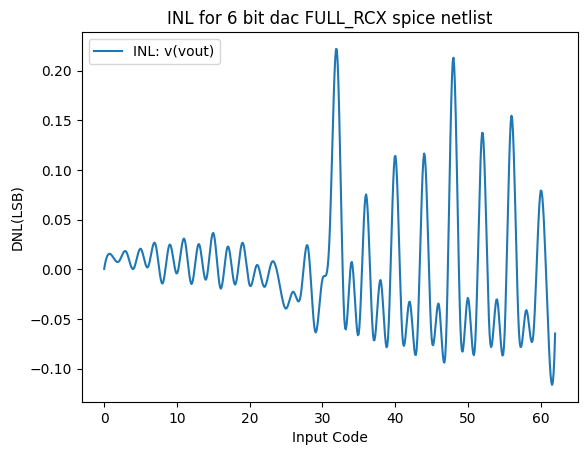

In [40]:
from scipy.interpolate import make_interp_spline
# Dataset

X_Y_Spline = make_interp_spline(range(len(INL)),INL)
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(0, len(INL)-1, spline_smoothing)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_,label='INL: '+vector_names[1])
plt.title("INL for "+str(no_of_bits)+" bit dac FULL_RCX spice netlist")
plt.ylabel("DNL(LSB)")
plt.xlabel("Input Code")
plt.legend()
plt.show()

## Plotting DNL

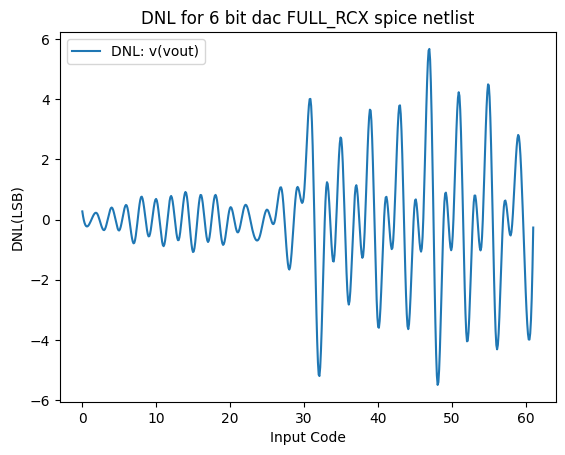

In [41]:
from scipy.interpolate import make_interp_spline
# Dataset

X_Y_Spline = make_interp_spline(range(len(dnl)),dnl)
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(0, len(dnl)-1, spline_smoothing)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_,label='DNL: '+vector_names[1])
plt.title("DNL for "+str(no_of_bits)+" bit dac FULL_RCX spice netlist")
plt.ylabel("DNL(LSB)")
plt.xlabel("Input Code")
plt.legend()
plt.show()

## Combined INL DNL plot

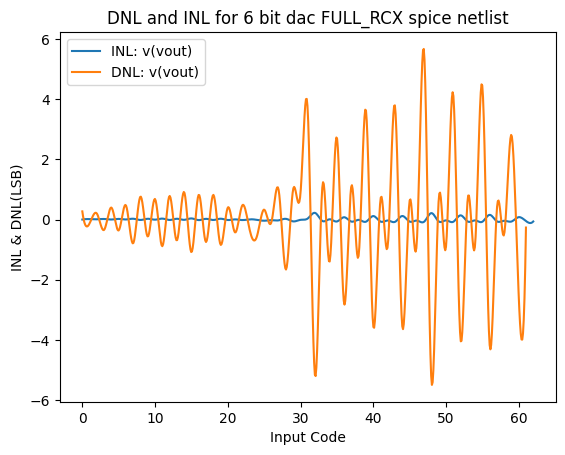

In [42]:
X_Y_Spline_INL = make_interp_spline(range(len(INL)),INL)
X_INL = np.linspace(0, len(INL)-1, spline_smoothing)
Y_INL = X_Y_Spline_INL(X_INL)
 
X_Y_Spline_DNL = make_interp_spline(range(len(dnl)),dnl)
X_DNL = np.linspace(0, len(dnl)-1, spline_smoothing)
Y_DNL = X_Y_Spline_DNL(X_DNL)

# Plotting the Graph
plt.plot(X_INL, Y_INL,label='INL: '+vector_names[1])
plt.plot(X_DNL, Y_DNL,label='DNL: '+vector_names[1])
plt.title("DNL and INL for "+str(no_of_bits)+" bit dac FULL_RCX spice netlist")
plt.ylabel("INL & DNL(LSB)")
plt.xlabel("Input Code")
plt.legend()
plt.show()